# Waveform

Speech signals are sound signals, defined as pressure variations
travelling through the air. These variations in pressure can be
described as waves and correspondingly they are often called sound
waves. In the current context, we are primarily interested in analysis
and processing of such waveforms in digital systems. We will therefore
always assume that the acoustic speech signals have been captured by a
microphone and converted to a digital form.

A speech signal is then represented by a sequence of numbers $ x_n $
, which represent the relative air pressure at time-instant $
n\in{\mathbb N} $ .  This representation is known as [pulse code
modulation](https://en.wikipedia.org/wiki/Pulse-code_modulation) often
abbreviated as *PCM*. The accuracy of this representation is then
specified by two factors; 1) the sampling frequency (the step in time
between $n$ and $n+1$) and 2) the accuracy and distribution of
amplitudes of $x_n$.

![waveform](attachments/148294966.png)

(content:samplingrate)=
## Sampling rate

[Sampling](https://en.wikipedia.org/wiki/Sampling_(signal_processing))
is a classic topic of signal processing. Here the most important aspect
is the Nyquist frequency, which is half the sampling rate
$F_s$ and defines the upper end of the largest bandwidth $
\left[0, \frac{F_s}2\right] $ which can be uniquely represented.
In other words, if the sampling frequency would be 8000 Hz, then signals
in the frequency range 0 to 4000 Hz can be uniquely described with this
sampling frequency. The AD-converter would then have to contain a
low-pass filter which removes any content above the Nyquist frequency.

The most important information in speech signals are the formants, which
reside in the range 300 Hz to 3500 Hz, such that a lower limit for the
sampling rate is around 7 or 8kHz. In fact, first digital speech codecs
like the AMR-NB use a sampling rate of 8 kHz known as narrow-band. Some
consonants, especially fricatives like /s/, however contain substantial
energy above 4kHz, whereby narrow-band is not sufficient for high
quality speech. Most energy however remains below 8kHz such that
wide-band, that is, a sampling rate of 16 kHz is sufficient for most
purposes. Super-wide band and full band further correspond,
respectively, to sampling rates of 32 kHz and 44.1 kHz (or 48kHz). The
latter is also the sampling rate used in compact discs (CDs). Such
higher rates are useful when considering also non-speech signals like
music and generic audio.

  


Frequency-range of different bandwidth-definitions

![bws](attachments/175528670.png)

## Static demo

Sound samples at different bandwidths

In [2]:
import IPython.display as ipd
print('Original (0 to 22050 Hz)')
ipd.display(ipd.Audio('sounds/speechexample.wav'))
print('Narrowband (300 Hz to 3.3 kHz)')
ipd.display(ipd.Audio('sounds/speechexample_300_3300.wav'))
print('Wideband (50 Hz to 7 kHz)')
ipd.display(ipd.Audio('sounds/speechexample_50_7000.wav'))
print('Superwideband (50 Hz to 16 kHz)')
ipd.display(ipd.Audio('sounds/speechexample_50_16000.wav'))
print('Fullband (50 Hz to 22 kHz)')
ipd.display(ipd.Audio('sounds/speechexample_50_22000.wav'))


Original (0 to 22050 Hz)


Narrowband (300 Hz to 3.3 kHz)


Wideband (50 Hz to 7 kHz)


Superwideband (50 Hz to 16 kHz)


Fullband (50 Hz to 22 kHz)


## On-line demo

### Original sound sample

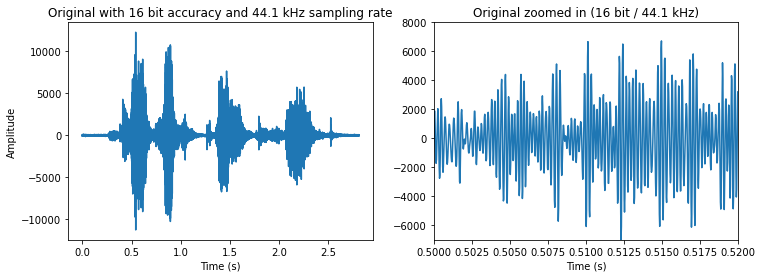

In [1]:
from ipywidgets import *
import IPython.display as ipd
import numpy as np
import scipy
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

filename = 'sounds/test.wav'
fs, data = wavfile.read(filename)
data = data.astype(np.int16)

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(nrows=1,ncols=2)
t = np.arange(0.,len(data))/fs
ax[0].plot(t,data)
ax[0].set_title('Original with 16 bit accuracy and ' + str(fs/1000) + ' kHz sampling rate')
ax[1].plot(t,data)
ax[1].set_title('Original zoomed in (16 bit / ' + str(fs/1000) + ' kHz)')
ax[1].set(xlim=(0.5,0.52),ylim=(-7000,8000))
ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
plt.show()

import IPython.display as ipd
ipd.display(ipd.Audio(filename))

### Resampling

In [2]:
def update(sampling_rate=16000):
    ipd.clear_output(wait=True)
    resample_ratio = sampling_rate/fs
    data_resample = signal.resample(data, int(len(data)*resample_ratio))
    data_resample = signal.resample(data_resample, len(data))
    data_resample = (data_resample*.7*(2**14)/np.max(np.abs(data_resample))).astype(np.int16)
    t = np.arange(0.,len(data_resample))/fs
    fig = plt.figure(figsize=(12, 4))
    ax = fig.subplots(nrows=1,ncols=2)
    ax[0].plot(t,data_resample)
    ax[0].set_title(str(sampling_rate/1000) + ' kHz sampling rate')
    ax[1].plot(t,data_resample)
    ax[1].set_title('Zoom in with ' + str(sampling_rate/1000) + ' kHz')
    ax[1].set(xlim=(0.5,0.52),ylim=(-7000,8000))
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    plt.show()
    fig.canvas.draw()
    wavfile.write("sounds/temp.wav", fs, data_resample.astype(np.int16))
    
    ipd.display(ipd.Audio('sounds/temp.wav'))
    
    


interact(update, sampling_rate=(2000, fs, 500));

interactive(children=(IntSlider(value=16000, description='sampling_rate', max=44100, min=2000, step=500), Outp…

## Accuracy and distribution of steps on the amplitude axis

In digital representations of a signal you are forced to use a finite
number of steps to describe the amplitude. In practice, we must quantize
the signal to some discrete levels.


### Linear quantization

Linear quantization with a step size $\Delta q $ would correspond
to defining the quantized signal as 

$$ 
\hat x = \Delta q\,\cdot {\mathrm{round}}(x/\Delta q). 
$$

The intermediate representation, $ y={\mathrm{round}}(x/\Delta q),$ 
can then be taken to represent, for example, signed 16-bit integers.
Consequently, the quantization step size  $ \Delta q $ has to be
then chosen such that $y$ remains in the range  $
y\in(-2^{15},\,2^{15}] $ to avoid numerical overflow.

The beauty of this approach is that it is very simple to implement. The
drawback is that this approach is sensitive to the choice of the
quantization step size. To make use of the whole range and thus get best
accuracy for $x$, we should choose the smallest  $ \Delta q $ where
we still remain within the bounds of integers. This is difficult because
the amplitudes of speech signals vary on a large range. 




![quant](attachments/149882928.png)
  

In [3]:
def update(sampling_rate=16000, bits=8):
    ipd.clear_output(wait=True)
    resample_ratio = sampling_rate/fs
    data_resample = signal.resample(data, int(len(data)*resample_ratio))
    data_resample = signal.resample(data_resample, len(data))
    data_resample = (data_resample*.7*(2**14)/np.max(np.abs(data_resample))).astype(np.int16)
    qstep = 2**(16-bits)
    data_q = qstep*np.round(data_resample / qstep)
    t = np.arange(0.,len(data_q))/fs
    fig = plt.figure(figsize=(12, 4))
    ax = fig.subplots(nrows=1,ncols=2)
    ax[0].plot(t,data_q)
    ax[0].set_title(str(bits)+' bit accuracy and ' + str(sampling_rate/1000) + ' kHz sampling rate')
    ax[1].plot(t,data_q)
    ax[1].set_title('Zoom in with '+str(bits)+' bit / ' + str(sampling_rate/1000) + ' kHz')
    ax[1].set(xlim=(0.5,0.52),ylim=(-7000,8000))
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    plt.show()
    fig.canvas.draw()
    wavfile.write("temp.wav", fs, data_q.astype(np.int16))
    
    ipd.display(ipd.Audio('temp.wav'))
    
    


interact(update, sampling_rate=(2000, fs, 500), bits=(1,16,1));

interactive(children=(IntSlider(value=16000, description='sampling_rate', max=44100, min=2000, step=500), IntS…

### Logarithmic quantization and mu-law

To retain equal accuracy for loud and weak signals, we *could* quantize
on an logarithmic scale as 
$$ \hat x = {\mathrm{sign}}(x)\cdot\exp\left[ \Delta
q\cdot\,{\mathrm{round}} \left(\log\left(\|x\|\right)/\Delta
q\right) \right]. $$
Such operations which limit the detrimental effects of limited range are
known as *[companding](https://en.wikipedia.org/wiki/Companding)*
algorithms.

Here the intermediate representation is  $ y = {\mathrm{round}}
\left(\log\left(\|x\|\right)/\Delta q\right) $ which can be
reconstructed by  $ \hat x = {\mathrm{sign}}(x)\cdot\exp\left[
\Delta q\cdot\,\|y\| \right]. $ A benefit of this approach would
be that we can encode signals on a much larger range and the
quantization accuracy is relative to the signal magnitude.
Unfortunately, very small values cause catastrophic problems. In
particular, for $x=0$, the intermediate value goes to negative infinity 
$ y=-\infty, $ which is not realizable in finite digital systems.

A practical solution to this problem is quantization with the mu-law
algorithm, which defines a modified logarithm as

$$
F(x):={\mathrm{sign}}(x)\cdot\,\frac{\log\left(1+\mu\|x\|\right)}{\left(1+\mu\right)}.
$$

By replacing the logarithm with $F(x)$, we retain the properties of the
logarithm for large $x$, but avoid the problems when $x$ is small.


![quant2](attachments/149882926.png)
![quant3](attachments/149882927.png)

## Wav-files

The most typical format for storing sound signals is the [wav-file
format](https://en.wikipedia.org/wiki/WAV). It is basically merely a way
to store a time sequence, with typically either 16 or 32 bit accuracy,
as integer, mu-law or float. Sampling rates can vary in a large range
between 8 and 384 kHz. The files typically have no compression (no
lossless nor lossy coding), such that recording hours of sound can
require a lot of disk space. For example, an hour of mono (single
channel) sound with a sampling rate of 44.1kHz requires 160 MB of disk
space.


## Adaptive quantization, APCM

-   To obtain a uniform quantization error during single phones or
    sentences, the quantization error has to change slowly over time.
-   In *adaptive quantization* (adaptive PCM or APCM) the quantization
    step size is adapted slowly such that
    -   the available quantization levels cover a sufficient range such
        that numerical overflow can be avoided,
    -   the quantization error is stable over time and
    -   as long as the above constraints are fulfilled, quantization
        error is minimized.
-   An alternative, equivalent implementation to the change in
    quantization step size is to apply an adaptive gain to the input
    signal before quantization.


![apcm1](attachments/175529208.png)
![apcm2](attachments/175529206.png)


### Adaptive quantization with the feed-forward algorithm using an adaptive quantization step

-   The feed-forward algorithm requires that in addition to the
    quantized signal, also the gain-coefficients or the quantization
    step is transmitted to the recipient.

    -   Transmitting such extra information increases the bit-rate,
        whereby the feed-forward algorithm is not optimal for
        applications which try to minimize transmission rate.


![waveform](attachments/175529207.png)

### Adaptive quantization with the feed-forward algorithm using an adaptive gain (compressor)

-   In *feed-backward* algorithms the quantization step or
    gain-coefficient is determined from previous samples which are
    already quantized.
-   Since the previous samples are available also at the decoder, the quantization step or gain-coefficient can be determined also at the decoder without extra transmitted information.
-   If the signal grows very rapidly, this approach can however not guarantee that there are no numerical overflows, since adaptation is performed only after quantization.


![waveform](attachments/175529205.png)

### Adaptive quantization with the feed-backward algorithm using an adaptive quantization step

-   Note that the feed-forward algorithms all require transmission of the scaling or gain coefficient, which can increase demand on bandwidth and adds to the complexity of the system.
-   The parallel transmission line can be avoided by predicting those
    coefficients from previously transmitted elements, with a
    feed-backward algorithm.


![waveform](attachments/175529204.png)


### Adaptive quantization with the feed-backward algorithm using an adaptive gain coefficient

-   The feed-backward algorithm can naturally be applied on gain
    adaptation as well.


![waveform](attachments/175529203.png)

#### Differential quantization DPCM

-   In *differential quantization* we predict the subsequent sample,
    whereby we can quantize only the difference between the prediction
    and the actual sample.
-   If the predictor is simply $ \tilde x_k:=x_{k-1}, $ then the error is $ e_k = x_k - \tilde x_k = x_k - x_{k-1}. $
-   The first difference (delta modulation) is the simplest  predictor, which uses the assumption that subsequent samples are highly correlated.
-   The reconstruction is obtained by reorganization of terms as $ x_k = e_k + x_{k-1}. $
-   Observe that the reconstruction is needed at both the encoder and decoder, to feed the predictor.
-   NB: At this point the flow-graphs start to get a bit complicated         as there are several feedback loops.
-   More generally, we can use a predictor $P$, which predicts a sample
    based on a weighted sum of previous samples    
    
    $$
    \tilde x_k = -\sum_{h=1}^M a_h x_{k-h}, 
    $$
    
    where the scalars  $ a_h $  are the predictor parameters.
-   A feed-backward would here use the past quantized samples $ \hat
    x_k. $


![waveform](attachments/175529209.png)

### Adaptive and differential quantization with feed-forward

-   The differential, source-model based quantization can naturally be combined with adaptive, perception-based quantization.
-   The adaptive differential PCM (ADPCM) adaptively predicts the signal and adaptively choosing the quantization step.


![waveform](attachments/175529202.png)

### Adaptive differential quantization with feed-backward

-   The ADPCM can again, naturally, be implemented as a feed-backward algorithm as well.

### Adaptive differential quantization w/ adaptive predictor

-   A differential quantizer can be further improved by letting also the
    predictor be adaptive.
-   The predictor learns adaptively properties of the signal.
-   The flow-graph becomes complicated and is omitted here.


![waveform](attachments/175529201.png)

### Comparison of the SNR of different quantizers (not perceptual)

-   The more bits we can use the better the quality (Duh!).
-   The more prior information we can use about the signal the better
    the efficiency (SNR/bits).
    -   More advanced models (can) improve quality.
    -   More parameters (can) improve quality.
    -   It would naturally also be entirely possible to create
        complicated models which do not improve quality, but simple
        models can go only so far.
-   The linear prediction -approach can be extended into a full-blown
    speech production model (see separate chapter).
-   Note that quality as measured by SNR does not necessarily reflect
    perceptual quality.

  
![waveform](attachments/175529210.png)
Adapted from {cite:p}`noll1975comparative`

  

## Source modelling in quantization

-   Adaptive quantization is based on our understanding of perception;
    we use the knowledge that we prefer slowly changing quantization
    errors.
    -   This is a simple *perceptual model*.
    -   Perceptual models are *quality evaluation* models.
-   When we know that the signal is *speech*, we can use that to further
    improve quantization.
    -   Models of speech signals are known as *source* models.
-   At its simplest form, we can use the fact that voiced phones are
    fairly continuous signals = they have low-pass character = are
    dominated by low-frequency components.
    -   Samples have a high correlation.
    -   The difference between subsequent samples is much smaller than
        the magnitude of samples!
-   The amplitude of the first difference is 41% of the original.
-   Uniform quantization of the first difference thus gives a 59%
    reduction in the range which is approx 1 bitsample. At 44kHz that
    would be 44kbit/s improvement in bitrate, which is definitely
    noticeable.


![source](attachments/175529216.png)


## Conclusion

-   Time-domain representation of speech signals is simple in
    floating-point processors.
    -   We only need to choose a sampling rate (typically in the range 8
        to 48 kHz).
-   For fixed-point and lower-bitrate representations, we have several
    considerations and options;
    -   We would like the quantization noise to be relative to the
        signal magnitude but stable over time for best perceptual
        quality.
    -   We can use information about signal properties to improve
        efficiency with a source model.
    -   If we want to reduce bit-rate, then we must make sure that the
        required information to decode the signal is available also at
        the receiving end.
-   Practical processing algorithms for speech operate on a digital
    representation of the acoustic signal.
    -   Accuracy is determined by sampling rate and quantization.
-   Most common (high-quality) storage format for digital speech and
    audio signals is PCM (such as WAV-files).
-   Some very basic analysis tools for speech signals include the
    autocorrelation and the zero-crossing rate.
-   Many classical DSP algorithms, in their flow-grap representation,
    are very much alike modern machine learning methods.

## Refrences

```{bibliography}
:filter: docname in docnames
```